<a href="https://colab.research.google.com/github/IanTirok/Climate-change-tweets-analysis/blob/main/Climate_change_Tensorflow_hub_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:

!pip install wandb
!wandb login

     |████████████████████████████████| 1.6 MB 5.0 MB/s 
     |████████████████████████████████| 97 kB 6.0 MB/s 
     |████████████████████████████████| 133 kB 53.1 MB/s 
     |████████████████████████████████| 170 kB 54.4 MB/s 
     |████████████████████████████████| 63 kB 1.6 MB/s 
  Created wheel for subprocess32: filename=subprocess32-3.5.4-py3-none-any.whl size=6502 sha256=29e27b1fbeea287eda1296826a992f6b33b0f1977da4d6ccd6144d555a5dbe03
  Stored in directory: /root/.cache/pip/wheels/50/ca/fa/8fca8d246e64f19488d07567547ddec8eb084e8c0d7a59226a
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=adc058f2fd5025e054ef7edf3ce6f18c37203c21151c288df0fa615c62795ab5
  Stored in directory: /root/.cache/pip/wheels/3e/31/09/fa59cef12cdcfecc627b3d24273699f390e71828921b2cbba2
Successfully built subprocess32 pathtools
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter: 
wan

In [ ]:
import tensorflow as tf
from tensorflow.python.distribute import distribution_strategy_context
from tensorflow.python.framework import ops
from tensorflow.python.framework import smart_cond
from tensorflow.python.framework import tensor_util
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.utils import losses_utils
from tensorflow.python.keras.utils import tf_utils
from tensorflow.python.keras.utils.generic_utils import deserialize_keras_object
from tensorflow.python.keras.utils.generic_utils import serialize_keras_object
from tensorflow.python.ops import array_ops
from tensorflow.python.ops import math_ops
from tensorflow.python.ops import nn
from tensorflow.python.ops.losses import losses_impl
from tensorflow.python.ops.losses import util as tf_losses_util
from tensorflow.python.util.tf_export import keras_export
from tensorflow.tools.docs import doc_controls

In [ ]:
import wandb
from wandb.keras import WandbCallback


In [ ]:
#Initialize wandb

run = wandb.init(project='Climate Change',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 5,
                     "batch_size": 64,
                     "loss_function": "sparse_categorical_crossentropy",
                     "architecture": "RNN",
                     "dataset": "CIFAR-10"
                 })
config = wandb.config 

wandb: Currently logged in as: kanoak (use `wandb login --relogin` to force relogin)


In [ ]:

# for i in range(10):
#   log_dict = {
#       "train_loss": 1/(i+1),
#       "custom_step": i**2,
#       "validation_loss": 1/(i+1) }
# wandb.log(log_dict)

In [ ]:
wandb.config.dropout = 0.2

Modelling using Tensorflow hub using a pretrained word embedding layer to classify tweets on climate change into classes

In [ ]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
#for text pre-processing
import re, string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import wordnet
from nltk.stem import WordNetLemmatizer
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
#for model-building
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.metrics import roc_curve, auc, roc_auc_score
# bag of words
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
#for word embedding
import gensim
from gensim.models import Word2Vec
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.util import ngrams
from spacy.lang.en import English
nlp = English()
import spacy
from nltk.stem import WordNetLemmatizer
  
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


## Load and preview data

In [ ]:
df = pd.read_csv('/content/Clean classified data_kwisha.csv')

In [ ]:
df.head()

,Unnamed: 0,id,location,created_at,retweet_count,class,clean_text,date,year,month,hour,minute
0,0,1427542334963605511,"Naples, Italy",2021-08-17 08:06:29,0,drought,wired climate change increase appearance viole...,2021-08-17 08:06:29,2021,8,8,6
1,1,1427540945260720136,United Arab Emirates,2021-08-17 08:00:58,0,greentalk,excite join pricelessplanet coalition commit p...,2021-08-17 08:00:58,2021,8,8,0
2,2,1427533126084014087,"Iten, Kenya",2021-08-17 07:29:54,6,drought,climate change negatively impact agricultural ...,2021-08-17 07:29:54,2021,8,7,29
3,3,1427531810662199313,Africa,2021-08-17 07:24:40,1,greentalk,enough even close let buckle climateaction mod...,2021-08-17 07:24:40,2021,8,7,24
4,4,1427526452623208453,Pacific North West,2021-08-17 07:03:23,0,floods,california need conservative propaganda save w...,2021-08-17 07:03:23,2021,8,7,3


In [ ]:
df.columns

Index(['Unnamed: 0', 'id', 'location', 'created_at', 'retweet_count', 'class',
       'clean_text', 'date', 'year', 'month', 'hour', 'minute'],
      dtype='object')

In [ ]:
df.head()

,Unnamed: 0,id,location,created_at,retweet_count,class,clean_text,date,year,month,hour,minute
0,0,1427542334963605511,"Naples, Italy",2021-08-17 08:06:29,0,drought,wired climate change increase appearance viole...,2021-08-17 08:06:29,2021,8,8,6
1,1,1427540945260720136,United Arab Emirates,2021-08-17 08:00:58,0,greentalk,excite join pricelessplanet coalition commit p...,2021-08-17 08:00:58,2021,8,8,0
2,2,1427533126084014087,"Iten, Kenya",2021-08-17 07:29:54,6,drought,climate change negatively impact agricultural ...,2021-08-17 07:29:54,2021,8,7,29
3,3,1427531810662199313,Africa,2021-08-17 07:24:40,1,greentalk,enough even close let buckle climateaction mod...,2021-08-17 07:24:40,2021,8,7,24
4,4,1427526452623208453,Pacific North West,2021-08-17 07:03:23,0,floods,california need conservative propaganda save w...,2021-08-17 07:03:23,2021,8,7,3


In [ ]:
df.to_csv('clean classified data.csv')

In [ ]:
df['class']

0         drought
1       greentalk
2         drought
3       greentalk
4          floods
          ...    
5421      drought
5422      drought
5423      drought
5424      drought
5425      drought
Name: class, Length: 5426, dtype: object

In [ ]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['clean_text'])


vocab_size = len(tokenizer.word_index) + 1  # Adding 1 because of reserved 0 index

EDA

renewable        2174
drought          1120
floods           1053
air_polutants     439
temperature       338
greentalk         302
Name: class, dtype: int64


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0, 0.5, 'class size')

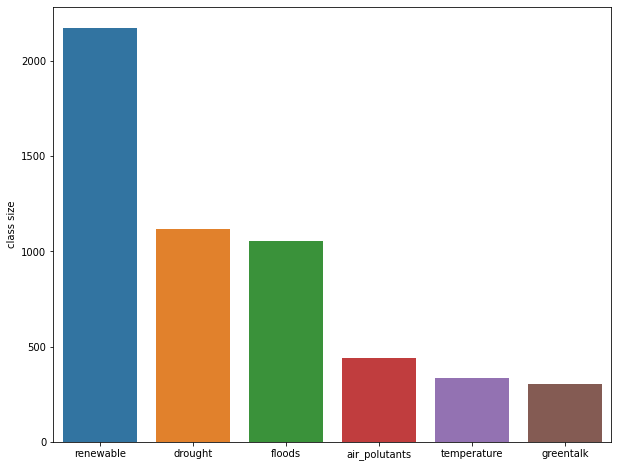

In [ ]:
#check the class distriburion
import seaborn as sns
import matplotlib.pyplot as plt
print(df['class'].value_counts())
x=df['class'].value_counts()
f, ax = plt.subplots(figsize=(10, 8))
sns.barplot(x.index,x)
plt.gca().set_ylabel('class size')

In [ ]:
# from sklearn import preprocessing
# le = preprocessing.LabelEncoder()
# df['class1'] = le.fit_transform(df['class'])

In [ ]:
! pip install wordcloud

In [ ]:
# from wordcloud import WordCloud
# import matplotlib.pyplot as plt
# wc = WordCloud()
# wc.generate(df.clean_text)
# plt.imshow(wc, interpolation="bilinear")
# plt.axis('off')
# plt.show()

## Dealing with class imbalance

In [ ]:
import tensorflow as tf
import os
import datetime
import tensorflow_hub as hub
from __future__ import absolute_import,division,print_function,unicode_literals

In [ ]:
# Get the counts of the target classes
df['class'].value_counts()

renewable        2174
drought          1120
floods           1053
air_polutants     439
temperature       338
greentalk         302
Name: class, dtype: int64

In [ ]:
# We split the dataset to train and test datasets, 80/20 split 
X_train,X_test,y_train,y_test=train_test_split(df,df["class"],test_size=0.2,random_state=111,)

We are going to assign class weights to deal with imbalance. Due to the difference in each class, the algorithms tend to get biased towards the majority values present and don’t perform well on the minority values.

The difference in weights will influence the classification of the classes during the training phase. The whole purpose is to penalize the misclassification made by the minority class by setting a higher class weight and at the same time reducing weight for the majority class. 

In [ ]:
# We compute classweights
from sklearn.utils import class_weight
class_weights=list(class_weight.compute_class_weight('balanced',np.unique(df['class']),df['class']))

In [ ]:
# We sort the class weights 
class_weights.sort()
class_weights

[0.4159766942655627,
 0.8074404761904762,
 0.8588160810383033,
 2.0599848139711465,
 2.675542406311637,
 2.9944812362030904]

In [ ]:
# we encode the target classes and assigning the class weights to each class index
weights={}
for index, weight in enumerate(class_weights):
  weights[index]=weight

In [ ]:
weights

{0: 0.4159766942655627,
 1: 0.8074404761904762,
 2: 0.8588160810383033,
 3: 2.0599848139711465,
 4: 2.675542406311637,
 5: 2.9944812362030904}

In [ ]:
#  Check the columns
df.columns

Index(['Unnamed: 0', 'id', 'location', 'created_at', 'retweet_count', 'class',
       'clean_text', 'date', 'year', 'month', 'hour', 'minute'],
      dtype='object')

In [ ]:
# Coverting the datasets into tensors. We feed the input X value and product
dataset_train=tf.data.Dataset.from_tensor_slices((X_train['clean_text'].values,X_train['class'].values))
dataset_test=tf.data.Dataset.from_tensor_slices((X_test['clean_text'].values,X_test['class'].values))

In [ ]:
# Coverting the datasets into tensors. We feed the input X value and product
dataset_train=tf.data.Dataset.from_tensor_slices((X_train['clean_text'].values,X_train['class'].values))
dataset_test=tf.data.Dataset.from_tensor_slices((X_test['clean_text'].values,X_test['class'].values))

In [ ]:
# Print text and target columns
for text, target in dataset_train.take(5):
  print('Tweet:{},Target:{}'.format(text,target))
print('************************')
for text, target in dataset_test.take(5):
  print('Tweet:{},Target:{}'.format(text,target))

Tweet:b'sudair solar pv project capacity gw large saudi arabiaand top globallywhen https co zuhxt',Target:b'renewable'
Tweet:b'provide harvest drought shortage',Target:b'drought'
Tweet:b'nick hamman http co z rbdup solar solution',Target:b'renewable'
Tweet:b'ca crisis bad dairy cattle industry kill animal urge ca help rancher trans https co vn l',Target:b'drought'
Tweet:b'climate change combine overfishing threatens food security nation https co pt f zwb',Target:b'drought'
************************
Tweet:b'shift away fossil fuel take time analyst say imperative south africa accelerate https co sfjcbngwot',Target:b'air_polutants'
Tweet:b'el ejido h mostly clear wind e gust temperature c humidity pressure http co q r gchj',Target:b'renewable'
Tweet:b'renewablejobs hi please renewable energy system engineering graduate look job placement noble office',Target:b'renewable'
Tweet:b'get caught flash flood bone still make alhamdulillah',Target:b'floods'
Tweet:b'aramco join group build giant sol

In [ ]:
# Convert target column from string to numerical using tensorflow lookup hash table
table=tf.lookup.StaticHashTable(
    initializer=tf.lookup.KeyValueTensorInitializer(
        keys=tf.constant(['renewable','drought','floods','air_polutants','temperature','greentalk']),
        values=tf.constant([0,1,2,3,4,5]),
    ),
    default_value=tf.constant(-1),
    name='target_encoding'
)
@tf.function #converts regular python code to a callable Tensorflow graph function, 
              #which is usually more performant and python independent
def target(x):
  return table.lookup(x)

In [ ]:
# Callable fi=unction that returns the class of text
def show_batch(dataset,size=5):
  for batch,label in dataset.take(size):
    print(batch.numpy())
    print(target(label).numpy())

In [ ]:
show_batch(dataset_test,5)

b'shift away fossil fuel take time analyst say imperative south africa accelerate https co sfjcbngwot'
3
b'el ejido h mostly clear wind e gust temperature c humidity pressure http co q r gchj'
0
b'renewablejobs hi please renewable energy system engineering graduate look job placement noble office'
0
b'get caught flash flood bone still make alhamdulillah'
2
b'aramco join group build giant solar plant saudiarabia business oott \xd8\xa7\xd9\x84\xd8\xb3\xd8\xb9\xd9\x88\xd8\xaf\xd9\x8a\xd8\xa9 \xd8\xa7\xd9\x84\xd9\x82\xd8\xb7\xd8\xa7\xd8\xb9 \xd8\xa7\xd9\x84\xd9\x86\xd9\x81\xd8\xb7\xd9\x8a https co xocgytwsxv'
0


We can print n-rows of target column and their target classes

In [ ]:
# Creating a fetch function to pass and return text value as is. Also we one encode the target value
def fetch(text,labels):
  return text,tf.one_hot(target(labels),6)

In [ ]:

# Map the fetch function to the train and test dataset 
train_data_f=dataset_train.map(fetch)
test_data_f=dataset_test.map(fetch)

In [ ]:
next(iter(train_data_f))

(<tf.Tensor: shape=(), dtype=string, numpy=b'sudair solar pv project capacity gw large saudi arabiaand top globallywhen https co zuhxt'>,
 <tf.Tensor: shape=(6,), dtype=float32, numpy=array([1., 0., 0., 0., 0., 0.], dtype=float32)>)

In [ ]:
# Creates batches of tensors in tensors
train_data,train_labels=next(iter(train_data_f.batch(5)))
train_data,train_labels

(<tf.Tensor: shape=(5,), dtype=string, numpy=
 array([b'sudair solar pv project capacity gw large saudi arabiaand top globallywhen https co zuhxt',
        b'provide harvest drought shortage',
        b'nick hamman http co z rbdup solar solution',
        b'ca crisis bad dairy cattle industry kill animal urge ca help rancher trans https co vn l',
        b'climate change combine overfishing threatens food security nation https co pt f zwb'],
       dtype=object)>, <tf.Tensor: shape=(5, 6), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0.]], dtype=float32)>)

In [ ]:
# Creating a embedding layer by using pretrained embedding layer to enable us to convert each word into a fixed length vector of defined size
embedding='https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1'
hub_layer=hub.KerasLayer(embedding,output_shape=[128],input_shape=[],
                        dtype=tf.string,trainable=True)# The output shape is 128
hub_layer(train_data[:1])

<tf.Tensor: shape=(1, 128), dtype=float32, numpy=
array([[-0.25857082, -0.03358521,  0.18653055, -0.2388049 ,  0.20501457,
         0.02456775,  0.01860405, -0.13713637, -0.15329532,  0.2732744 ,
        -0.01152269,  0.11092133,  0.09912161, -0.02110232,  0.06281215,
        -0.12594002,  0.1148983 ,  0.0663828 ,  0.03998982, -0.00171762,
        -0.02013695, -0.32855833,  0.241918  , -0.05570541,  0.03161884,
        -0.1263835 ,  0.01395128,  0.1453646 , -0.05246278,  0.0376394 ,
         0.17924018, -0.09233581, -0.02648976, -0.08710196, -0.1615573 ,
        -0.03817734,  0.00301067,  0.02174203,  0.08918054,  0.04608176,
        -0.07785966,  0.05985419, -0.11454432,  0.00988869, -0.03962754,
        -0.07149867, -0.03534734, -0.06996195, -0.0205115 ,  0.04312464,
        -0.11168173,  0.14624771, -0.18595003,  0.05579992, -0.14118056,
         0.10367499,  0.00039232, -0.08509452,  0.11058893,  0.15159303,
         0.04082303,  0.05383445, -0.05944769, -0.00292218, -0.02368171,
 

In [ ]:
# We create a keras sequential model.
# Sequential groups a linear stack of layers into a tf.keras.Model.
# Sequential provides training and inference features on this model.

model=tf.keras.Sequential()
model.add(hub_layer)
for units in [128,128,64,32]:
  model.add(tf.keras.layers.Dense(units,activation='relu'))
  model.add(tf.keras.layers.Dropout(0.3))

# We specify the output as 6 predicted values 
model.add(tf.keras.layers.Dense(6,activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

In [ ]:
# Initialize wandb with your project name
run = wandb.init(project='my-keras-integration',
                 config={  # and include hyperparameters and metadata
                     "learning_rate": 0.005,
                     "epochs": 5,
                     "batch_size": 64,
                     "loss_function": "categorical_crossentropy",
                     "architecture": "RNN",
                     "dataset": "df"
                     })

In [ ]:
# We compile using adam optimizer
config = wandb.config  # We'll use this to configure our experiment
tf.keras.backend.clear_session()

model.summary()
model.compile(optimizer=tf.keras.optimizers.Adam(config.learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 128)               124642688 
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dropout_2 (Dropout)          (None, 64)                0

We will evaluate the model using different metrics

In [ ]:
# We shuffle and train the train and test data
train_data_f=train_data_f.shuffle(70000).batch(512)
test_data_f=test_data_f.batch(512)

In [ ]:
# Create a copy of our model
model2=model

In [ ]:
# we train the data using 10 epochs and using class weights. bias is therefore introduced to the model and computed.
# we will perform checks to ensure each class performs well
history=model.fit(train_data_f,epochs=10,
                  validation_data=test_data_f, class_weight=weights,
                  verbose=1)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/keras/backend.py:4847: UserWarning: "`categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a sigmoid or softmax activation and thus does not represent logits. Was this intended?"
  '"`categorical_crossentropy` received `from_logits=True`, but '


9/9 [==============================] - 16s 2s/step - loss: 1.7883 - accuracy: 0.2071 - val_loss: 1.7405 - val_accuracy: 0.4365
Epoch 2/10
9/9 [==============================] - 13s 1s/step - loss: 1.7434 - accuracy: 0.2788 - val_loss: 1.6402 - val_accuracy: 0.5497
Epoch 3/10
9/9 [==============================] - 13s 1s/step - loss: 1.6445 - accuracy: 0.3565 - val_loss: 1.4455 - val_accuracy: 0.6289
Epoch 4/10
9/9 [==============================] - 15s 2s/step - loss: 1.4715 - accuracy: 0.4541 - val_loss: 1.1580 - val_accuracy: 0.6998
Epoch 5/10
9/9 [==============================] - 13s 1s/step - loss: 1.2158 - accuracy: 0.5781 - val_loss: 0.9005 - val_accuracy: 0.7606
Epoch 6/10
9/9 [==============================] - 14s 1s/step - loss: 0.9493 - accuracy: 0.6737 - val_loss: 0.7155 - val_accuracy: 0.7956
Epoch 7/10
9/9 [==============================] - 13s 1s/step - loss: 0.7035 - accuracy: 0.7654 - val_loss: 0.6097 - val_accuracy: 0.8168
Epoch 8/10
9/9 [=============================

The  metrics after the 10th epoch/ loss: 0.2752 - accuracy: 0.9191 - val_loss: 0.5834 - val_accuracy: 0.8425
The model is performing well

In [ ]:
loss, accuracy = model.evaluate(dataset_test.map(fetch).batch(1121),verbose=2)
print('Test Error Rate: ', round((1 - accuracy) * 100, 2))

# With wandb.log, we can easily pass in metrics as key-value pairs.
wandb.log({'Test Error Rate': round((1 - accuracy) * 100, 2)})

run.join()

1/1 - 0s - loss: 0.5834 - accuracy: 0.8425
Test Error Rate:  15.75


epoch,9
loss,0.27521
accuracy,0.91912
val_loss,0.58338
val_accuracy,0.84254
_runtime,225
_timestamp,1629352400
_step,10
best_val_loss,0.56766
best_epoch,8
Test Error Rate,15.75


epoch,▁▂▃▃▄▅▆▆▇█
loss,██▇▇▅▄▃▂▂▁
accuracy,▁▂▂▃▅▆▆▇██
val_loss,█▇▆▅▃▂▁▁▁▁
val_accuracy,▁▃▄▆▇▇████
_runtime,▁▂▃▄▄▅▆▇▇██
_timestamp,▁▂▃▄▄▅▆▇▇██
_step,▁▂▂▃▄▅▅▆▇▇█
Test Error Rate,▁


In [ ]:
# check the length of the test dataset
len(list(dataset_test))



1086

In [ ]:
# craete a batch of the dataset and pass the model through entire dataset
results=model.evaluate(dataset_test.map(fetch).batch(1121),verbose=2)
print(results)

# we pass model through the test data and map the fetch function.
test_data,test_labels=next(iter(dataset_test.map(fetch).batch(10000)))
# Predict the target class
y_pred=model.predict(test_data)
# Check the model performance using classification and confusion matrix
print(classification_report(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))

1/1 - 1s - loss: 0.5834 - accuracy: 0.8425
[0.5833842158317566, 0.8425414562225342]
              precision    recall  f1-score   support

           0       0.93      0.87      0.90       452
           1       0.90      0.87      0.89       217
           2       0.83      0.86      0.85       210
           3       0.62      0.72      0.67        80
           4       0.81      0.78      0.79        64
           5       0.55      0.73      0.63        63

    accuracy                           0.84      1086
   macro avg       0.77      0.81      0.79      1086
weighted avg       0.85      0.84      0.85      1086



The accuracy of the model is 83%

In [ ]:
# we pass model through the test data and map the fetch function.
test_data,test_labels=next(iter(dataset_test.map(fetch).batch(10000)))


In [ ]:
# Predict the target class
y_pred=model.predict(test_data)
# Check the model performance using classification and confusion matrix
print(classification_report(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       452
           1       0.90      0.87      0.89       217
           2       0.83      0.86      0.85       210
           3       0.62      0.72      0.67        80
           4       0.81      0.78      0.79        64
           5       0.55      0.73      0.63        63

    accuracy                           0.84      1086
   macro avg       0.77      0.81      0.79      1086
weighted avg       0.85      0.84      0.85      1086



In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# Check the model performance using classification and confusion matrix
print(classification_report(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))

              precision    recall  f1-score   support

           0       0.93      0.87      0.90       452
           1       0.90      0.87      0.89       217
           2       0.83      0.86      0.85       210
           3       0.62      0.72      0.67        80
           4       0.81      0.78      0.79        64
           5       0.55      0.73      0.63        63

    accuracy                           0.84      1086
   macro avg       0.77      0.81      0.79      1086
weighted avg       0.85      0.84      0.85      1086



In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1))

array([[391,   5,  21,  20,   2,  13],
       [  7, 189,   9,   2,   4,   6],
       [  4,   7, 181,   7,   3,   8],
       [  6,   6,   2,  58,   1,   7],
       [  5,   2,   3,   1,  50,   3],
       [  7,   0,   2,   6,   2,  46]])

The accuracy is accuracy score is 84%, 

## Challenging the solution
We will model our data without using class weights

In [ ]:
# we train the data using 10 epochs and without using class weights
# we will perform checks to ensure each class performs well
weightless=model2.fit(train_data_f,epochs=10,
                  validation_data=test_data_f,
                  verbose=1)
# check the length of the test dataset
len(list(dataset_test))
# craete a batch of the dataset and pass the model through entire dataset
result=model2.evaluate(dataset_test.map(fetch).batch(1121),verbose=2)
print(result)

# we pass model through the test data and map the fetch function.
test_data,test_labels=next(iter(dataset_test.map(fetch).batch(10000)))
# Predict the target class
y_pred=model2.predict(test_data)


In [ ]:
# Check the model performance using classification and confusion matrix
print(classification_report(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1)))
print('\n')
confusion_matrix(test_labels.numpy().argmax(axis=1),y_pred.argmax(axis=1))